# RSCAM Week 5 exercises

_(Updated Friday February 15th 2019)_

**[0] Please rename your submitted file in the format `firstname_lastname.ipynb` using _File->Rename_.**

### The Rosenbrock problem

An important test for any sampling application is how long it takes the algorithm to traverse barriers (such as in the previous weeks), but also how long it takes to explore the surrounding space. We can count barrier hops to test the former, but what about the latter?

We can use the autocorrelation time to give us an idea of the decorrelation rate of the slgorithm. If it samples "iid" then the autocorrelation time is 1, because every sample is decorrelated from one another.


We will be looking at the Rosenbrock _banana_ problem. In two dimensions $[x,y]=q\in\mathbb{R}^2$ we have $\rho(x,y) \propto \exp(-U(x,y))$ as usual, where

$$ U(x,y) =  (1-x)^2 + 4( 2y-x^2)^2 $$

We plot the energy function below:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def U(x,y):
    
    return (1-x)**2 + 4*(2*y-x**2)**2

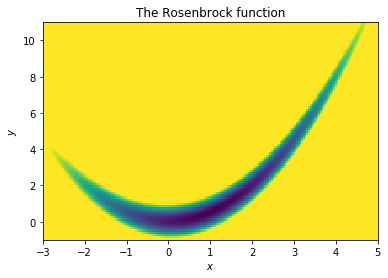

In [3]:
X,Y = np.meshgrid( np.linspace(-3,5,200) , np.linspace(-1,11,100) )
rho = U(X,Y)
plt.pcolor(X,Y,rho,vmin=0,vmax=15)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('The Rosenbrock function')
plt.show()

The distribution defined by this energy function has a strong curvature that can make travelling around the space tricky.

As we have seen, we may use numerical methods to generate points distributed according to the distribution $\rho$ however this may introduce a bias in the form of discretization error. We can use a Metropolis (or Metropolis-Hastings) test to correct for this error to remove the bias. We can even use these tests to transform any reversible stepping method to sample perfectly a given distribution (although it may not necessarily be efficient).

The quintessential example of this is the Metropolis Random Walk scheme.

$$ \left| \begin{array}{rcl} 
R_t&\leftarrow&\text{Normal}(0,1)\\
S_t&\leftarrow&\text{Uniform}(0,1)\\
\qquad q^*_{t+1}&\leftarrow&q_t + h\, R_t\\
\text{If } S_t &<& \rho(q^*_{t+1} )/\rho(q_t) \text{ then:}\\
\qquad \textit{(accept)}\\
\qquad q_{t+1} &\leftarrow& q^*_{t+1}\\
\text{otherwise:}\\
\qquad \textit{(reject)}\\
\qquad q_{t+1} &\leftarrow& q_t\\
\text{end if}
\end{array}\right.$$

Note here that we don't need to know the normalization constant for $\rho$, as we only care about the ratio between the $\rho$ at the _proposed_ point $q^*$ and the _current_ point $q$.

**[1] Code a version of the Metropolis algorithm below. It should take as input the current position $q$ and a stepsize $h$. It should output the new position $q$ and an integer ($1$ if new point was accepted, $0$ if new point was rejected). **


In [68]:
def rho(q):
    x = q[0]
    y = q[1]
    
    return np.exp(-U(x,y))

def Metropolis(q0,h):
    
    # Your code here
    R_t = np.random.randn(len(q0))
    S_t = np.random.uniform(0,1)
    q_temp = q0 + h*R_t
    if S_t < rho(q_temp)/rho(q0):
        q_new = q_temp
        accept = 1
    else:
        q_new = q0
        accept = 0
    return q_new, accept    

We can plug this algorithm into the `run_simulation` routine like this:

In [5]:
def run_simulation( q0, Nsteps, h, step_function):
    
    
    q_traj = [np.copy(q0)]  

    q = np.copy(q0)  
    total_accepted = 0

    for n in range(Nsteps):
        q, accepted = step_function(q, h) 

        q_traj += [q]  
        total_accepted += accepted

    q_traj = np.array(q_traj)   

    return q_traj, total_accepted/Nsteps
    

Running is then easy:

Acceptance probability: 0.508


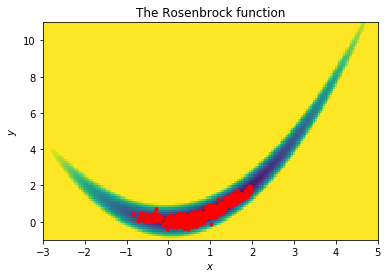

In [6]:
q0 = [1.0,1.0/2]
Nsteps = 1000
h = 0.25
q_traj, acc = run_simulation( q0, Nsteps, h, Metropolis) 
print('Acceptance probability: ' + str(acc))

X,Y = np.meshgrid( np.linspace(-3,5,200) , np.linspace(-1,11,100) )
plt.pcolor(X,Y,U(X,Y),vmin=0,vmax=15)
plt.plot(q_traj[:,0],q_traj[:,1],'r.')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('The Rosenbrock function')
plt.show()


The acceptance rate should be around $0.45$ here, so nearly half of the new points are accepted. It should be clear that increasing $h$ will make bigger moves in space, but the probability of them being accepted will decrease. Smaller $h$ will make smaller moves, but the acceptance probability will increase (_try this yourself if you wish_).

This begs the question: what's the best choice for $h$? Do we want rare-but-large moves, or frequent-but-small moves? This is not an easy question to answer in general, but one way to check is to look at the autocorrelation time.

Consider an infinitely long trajectory $\Phi=\{\phi_1,\,\phi_2,\,\ldots\}$ of points from a numerical method, where $\phi_i=\phi(q_i)$ and each $\phi_i\in\mathbb{R}$. Let us consider the mean over the whole trajectory, which we can write with a bar over a function, as

$$\overline{f(\phi_i)} = \lim_{n\to\infty} \frac1n \sum_{i=1}^n f(\phi_i) $$

In practice we can estimate this value by considering a trajectory of finite length, and just averaging over that.

The _autocorrelation function_ can be defined as 

$$\text{autocorr}(k;\,\Phi) = \frac{\overline{(\phi_i - \mu)(\phi_{i+k} - \mu)} }{\overline{(\phi_i - \mu)^2 }}$$

where $k\in\mathbb{N}\cup\{0\}$ is called the _lag_, and we have denoted $\mu = \overline{\phi_i}$ as the average of $\phi$ over the trajectory. As we don't have an infinite trajectory from our simulation in practice, we estimate the value as best as we can for each $k$, and at $k$ large this means that we don't have many points to average over. It should be clear that at $k=0$ this function will be $1$, but as $k$ gets large the lack of points to average will result in a noisier estimate of the $n\to\infty$ limiting case,

The autocorrelation function shows how quickly the method decorrelates from the initial condition. Decorrelation is good, it means that as we move to a new point we _forget_ our initial conditions, which is tantamount to mixing faster.

**[3] Create a function `acf` that takes in a trajectory $\Phi$, and a max lag `kmax`, and outputs the autocorrelation function between $0$ and $k$ (so a vector of length `kmax`$+1$).**

** Plot the autocorrelation functions for $\phi(q)=y$ (i.e. the $y$ component) of trajectories generated using the Metropolis Random Walk scheme on the Rosenbrock example, using $h=0.25$, $0.5$, and $1.0$ using $100000$ steps, and for max lag 100 steps.**

*(Don't forget to use axis labels and legends here and whenever you plot things to answer a handin question.)*

You should see that the correlations decay as a function of number of steps $k$, with the largest $h$ (giving the smallest acceptance rate) most rapidly decorrelating.

In [17]:
def acf(Phi,kmax):
    
    acf = np.zeros(kmax+1)
    E_Phi = np.mean(Phi)
    
    for k in range(kmax+1):
        acf[k] = np.mean((Phi[0:-1-k]-E_Phi)*(Phi[k:-1]-E_Phi))/(np.mean((Phi-E_Phi)**2))
    
    return acf

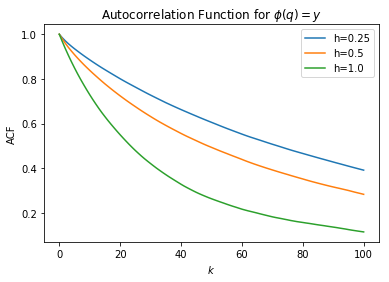

In [22]:
q0 = [1.0,1.0/2]
Nsteps = 100000
H = [0.25,0.5,1.0]
kmax = 100

for h in H:
    q_traj, acc = run_simulation( q0, Nsteps, h, Metropolis)
    ac = acf(q_traj[:,1],kmax)
    plt.plot(range(kmax+1),ac, label='h='+str(h))
plt.xlabel('$k$')
plt.ylabel('ACF')
plt.title('Autocorrelation Function for $\phi (q) = y$')
plt.legend()
plt.show()
    

The integrated autocorrelation time $\tau$ for the function $\phi(q)$ can give us a measure of how quickly things decorrelate. This is related to the infinite sum of the autocorrelation function, and is explicitly calculated as:

$$\tau_\phi = 1 + 2 \sum_{k=1}^\infty \text{autocorr}(k;\, \Phi)$$

There is usually significant noise in the plot of the autocorrelation function, leading to a sum that grows as $k\to\infty$. In the limit of infinite sampling this noise dies away and the autocorrelation function tends to zero as $k$ increases. To overcome this noise in practice, a common technique is to zero values from the `acf` function for all $k$ beyond the first $k$ such that $\text{autocorr}(k)<0.01$. This will ensure a more stable result (if a slightly less accurate one).

**[4] Approximate $\tau_\phi$ for the three trajectories you ran in Q3.**

*(Hint: You should make use of the approximation mentioned above, and will likely need to compute a longer acf than you did in Q3. If you wish, to get a more accurate answer you can try computing an acf from running longer trajectories.)*


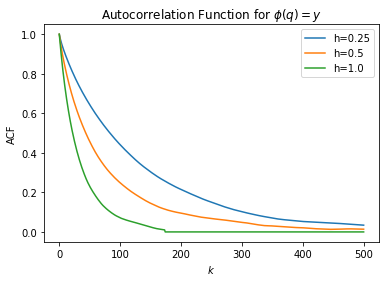

In [45]:
# PLEASE INCREASE Nsteps if accuracy is concerned
q0 = [1.0,1.0/2]
Nsteps = 100000
H = [0.25,0.5,1.0]
kmax = 500
# autocorrelation time
act = np.zeros(len(H)) 
itr=0 

for h in H:
    q_traj, acc = run_simulation( q0, Nsteps, h, Metropolis)
    ac = acf(q_traj[:,1],kmax)
    # Applying the zeroing technique
    k_index = np.where(ac<0.01)[0]
    if k_index.size>0:
        k_index = k_index[0]
        ac[k_index:] = 0
        
    # Calculate Autcorrelation Time    
    act[itr] = 1 + 2* np.sum(ac)
    itr += 1
    
    # Plotting each time step acf curve
    plt.plot(range(kmax+1),ac, label='h='+str(h))
    
plt.xlabel('$k$')
plt.ylabel('ACF')
plt.title('Autocorrelation Function for $\phi (q) = y$')
plt.legend()
plt.show()
    

In [46]:
print('The autocorrelation time for each h respectively')
print(act)

The autocorrelation time for each h respectively
[251.4505683  157.1278592   71.41248228]


We can use this $\tau$ value to approximate the asymptotic variance that we expect to see in our computed average. We will denote $\hat{\phi}$ as our observed average of $\phi$ after $N$ steps of the numerical scheme, so $\hat{\phi} = \frac1N\sum_{i=1}^N \phi_i$. If we run lots of independent simulations, you can imagine that we will get slightly different answers every time we run, due to the random nature of the schemes. The variance of our estimate of the mean can be computed via the central limit theorem, which says that as the number of steps $N$ gets large

$$ \text{var}(\hat{\phi}) \to \frac{(\text{Av}(\phi^2)-\text{Av}(\phi)^2) \tau_\phi}{N} $$

Recall that $\text{Av}(\bullet)$ denotes the true average with respect to $\rho$. The value $\text{var}(\hat{\phi})$ can be thought of as the _error_ we expect in our computed average: the expected variation in our estimate. An efficient method will have a small variance.

**[5] Approximate $\text{var}(\hat{\phi})$ when $N=10000$ using Metropolis Random Walk with $h=0.5$, by computing the variance of the computed $\hat{\phi}$ over fifty independent experiments, using $\phi(q)=y$ as before.**

*(You should find a value somewhere between 0.005 and 0.01)*

In [92]:
q0 = [1.0,1.0/2]
Nsteps = 10000
h = 0.5
kmax = 200

# number of experiments
nb_exp = 50
# vector for saving the variance for each experiment
var_phi = np.zeros(nb_exp)

for n in range(nb_exp):
    q_traj, acc = run_simulation( q0, Nsteps, h, Metropolis)
    ac = acf(q_traj[:,1],kmax)

    # Applying the zeroing technique
    k_index = np.where(ac<0.01)[0]
    if k_index.size>0:
        k_index = k_index[0]
        ac[k_index:] = 0
    act = 1 + 2* np.sum(ac)
    var_phi[n] = act*(np.mean(q_traj[:,1]**2)-np.mean(q_traj[:,1])**2)/len(q_traj[:,1])
    
var_phi_avg = np.mean(var_phi)
print('The variance of our estimate of the mean')
print(var_phi_avg)

The variance of our estimate of the mean
0.006640651938252244


We can compare this variance to the theoretical result, as long as we have the exact average value. 
In this example we can compute the exact averages to arbitrary accuracy via a double-Riemann Sum, i.e. recall that we can write

$$ \int_A^B f(x) \text{d}x \approx \sum_{i=1}^N f(x_i) \Delta x$$

for a small enough $\Delta x$ and a choice of points $x_i\in[A,B]$. This will  approximate the (double) integral as a discrete sum in space.

**[6] Use a Riemann Sum (or other integration routine) to show that $(\text{Av}(\phi^2)-\text{Av}(\phi)^2)\approx0.66$ where recall**
$$\text{Av}(f(x,y)) := \int_{-\infty}^\infty\int_{-\infty}^{\infty} f(x,y) \rho(x,y) \text{d}x\text{d}y,\qquad  \rho(x,y) = \frac{\exp(-U(x,y))}{\int_{-\infty}^\infty \exp(-U(x,y))\text{d}x\text{d}y}$$

_(Hint: Though the integral is to $\pm\infty$, computing the integral in a box $x\in[-4,6]$, $y\in[-2,15]$ will suffice as $\rho$ becomes extremely small outside of that region. Your code should be able to compute this quickly, without loops. )_

In [91]:
# function to define the product of f and rho without the normalizing constant
def frho(q,power):
    x = q[0]
    y = q[1]
    
    return (y**power)*np.exp(-U(x,y))

xi = np.linspace(-4,6,100)
yi = np.linspace(-2,15,1001)

X,Y = np.meshgrid(xi,yi)
q = [X,Y]

frho_phisq = frho(q,2)/np.sum(np.sum(rho(q),axis=0))
av_phisq = np.sum(np.sum(frho_phisq,axis=0))

frho_phi = frho(q,1)/np.sum(np.sum(rho(q),axis=0))
av_phi = np.sum(np.sum(frho_phi,axis=0))

from IPython.display import Latex
display(Latex(' $Av(\phi^2)-Av(\phi)^2 = $'))
print(av_phisq-av_phi**2)

<IPython.core.display.Latex object>

0.6562499714976091


In [94]:
a = (av_phisq-av_phi**2)*act/len(q_traj[:,1])
print(a)

0.010310420171137468


You should find that indeed
$$ \text{var}(\hat{\phi}) \approx \frac{(\text{Av}(\phi^2)-\text{Av}(\phi)^2) \tau_\phi}{N} $$
and so one way to reduce observed error (i.e. the variance) is to find methods that decorrelate quickly and minimize their integrated autocorrelation $\tau$ parameter.

Running for a larger $N$, or improving your estimation with more repeats, will improve this agreement.

***
As an alternative to the Metropolis random walk, we may consider using methods that use the force information to drive points in the correct direction. For that, we need a force routine:


**[7] Define a `force` function that takes a $q$ as input and outputs $-\nabla U(q)$ for the Rosenbrock given above.**

*(You can check that your gradient is correct by approximating the limit in the definition of the gradient by a small number, i.e. use $f'(x)\approx (f(x+h)-f(x))/h$ for a small value of $h$.)*

In [112]:
def force(q):
    x = q[0]
    y = q[1]
    # Your code here
    dU_dx = 2*(1-x) + 8*2*x*(2*y-x**2)
    dU_dy = -8*2*(2*y - x**2)
    return np.array([dU_dx,dU_dy])

In [113]:
# Test for force function
q1 = np.array([9,3])
h = 0.0002
q2 = q1+h
grad = force(q1)
appx = (U(q1[0],q1[1])-U(q2[0],q1[1]))/h
appy = (U(q1[0],q1[1])-U(q1[0],q2[1]))/h

print('force =',grad)
print('approximation in x=',appx)
print('approximation in y=',appy)

force = [-10816   1200]
approximation in x= -10816.379405732732
approximation in y= 1199.996800005465


We will be looking at the _Hybrid/Hamiltonian Monte Carlo_ method (HMC).  A good definition of the algorithm, along with pseudocode, is given in 

_MCMC using Hamiltonian dynamics_, Radford Neal (2011)

The whole article is relevant, but the algorithm itself can be found in Section 3.

**[8] Look up and implement the HMC algorithm in a function below. It should take as input the current position $q$ and a stepsize $h$. It should output the new position $q$ and an integer ($1$ if new point was accepted, $0$ if new point was rejected).**

**Run a simulation of 100000 steps at $h=0.2$ and plot the autocorrelation function of $\phi(q)=y$.**

Note that in their description, `epsilon` corresponds to $h$, while `rnorm` gives a normal random number and `runif` is a uniform random number. He also uses an $L$ parameter to define the number of steps to take, for this example you should set $L=1$.

You can test your routine using the `run_simulation` function. You should see that with $h=0.2$ you get an acceptance rate around $0.65$ or so.

In [130]:
def HMC(q0,h):
    
    # creating normal random vector
    p = np.random.randn(len(q0))    
    current_p = p
    # half step of p to calculate q
    # the sign is '+' because the negative in their 
    # algorithm multiplied by the gradient not the force
    p = current_p + h*force(q0)/2
    q = q0 + h*p
    
    # complete the step
    p = p + h*force(q)/2
    
    # reverse for symmetry
    p = -p
    
    current_U = U(q0[0],q0[1])
    current_K = sum(current_p**2) / 2
    proposed_U = U(q[0],q[1])
    proposed_K = sum(p**2)/2
    
    full = np.exp(current_U-proposed_U+current_K-proposed_K)
    S_t = np.random.uniform(0,1)
  
    if S_t < full:
        q_new = q
        accept = 1
    else:
        q_new = q0
        accept = 0
    return q_new, accept    

In [131]:
q0 = [1.0,1.0/2]
Nsteps = 100000
h = 0.2
q_traj, acc = run_simulation( q0, Nsteps, h, HMC) 
print('Acceptance probability: ' + str(acc))

Acceptance probability: 0.64504


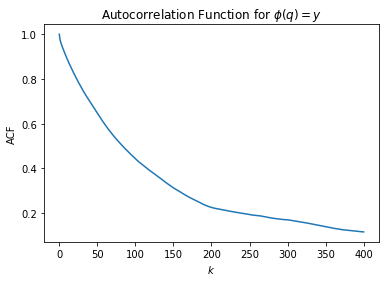

In [135]:
kmax = 400
ac = acf(q_traj[:,1],kmax)
plt.plot(range(kmax+1),ac)
plt.xlabel('$k$')
plt.ylabel('ACF')
plt.title('Autocorrelation Function for $\phi (q) = y$')
plt.show()

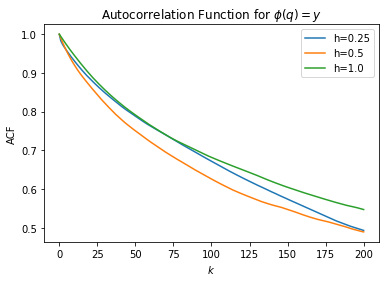

In [136]:
q0 = [1.0,1.0/2]
Nsteps = 100000
H = [0.25,0.5,1.0]
kmax = 200
# autocorrelation time
act = np.zeros(len(H)) 
itr=0 

for h in H:
    q_traj, acc = run_simulation( q0, Nsteps, h, HMC)
    ac = acf(q_traj[:,1],kmax)
    # Applying the zeroing technique
    k_index = np.where(ac<0.01)[0]
    if k_index.size>0:
        k_index = k_index[0]
        ac[k_index:] = 0
        
    # Calculate Autcorrelation Time    
    act[itr] = 1 + 2* np.sum(ac)
    itr += 1
    
    # Plotting each time step acf curve
    plt.plot(range(kmax+1),ac, label='h='+str(h))
    
plt.xlabel('$k$')
plt.ylabel('ACF')
plt.title('Autocorrelation Function for $\phi (q) = y$')
plt.legend()
plt.show()

***
If you experiment with the schemes, you should find that as you vary $h$ you do not get a significant improvement on decorrelation rate compared to the Metropolis Random Walk scheme. This is because in 2D it is very easy to come up with acceptable moves by doing something 'dumb' like adding a random number in any direction. In higher dimensions, this becomes significantly more challenging.

Now consider expanding our position space, so $[x,y,z_1,z_2,\ldots,z_{100}]=q\in\mathbb{R}^{102}$. We have $\rho(q) \propto \exp(-U(q))$ as usual, where

$$ U(q) =  (1-x)^2 + 4( 2y-x^2)^2 + \frac12 \sum_{i=1}^{100} z_i^2$$

It should be clear that all we have done is add 100 new $z$ variables. These $z$ variables are called _nuisance_ variables, as they do not interact with the $x$ and $y$. They do not affect the averages in the integrals either; if you write down the integrals then the $z$ variables can be integrated out and cancel. But they are useful for looking at how the numerical methods deal in a higher dimensional setting.

**[9] In this problem, which method, HMC or Metropolis Random Walk, do you think is more efficient at computing $\text{Av}(\phi)$, where $\phi(q)=y$?**

** Justify your answer by using Figures and writing markup text below.**

*(Only a general overview is necessary, no more than a few hundred words of markup. It is advisable to put the markup text first and refer to any Figures, and the code to generate them, underneath. Figures to support your argument should come from code run on this worksheet, do not import outside assets from e.g. other articles. You can answer this in many different ways, there is not necessarily one right answer.)*

**My Answer**
***
New functions for higher dimensional U are written down and the autocorrelation function for both methods are plotted. The HMC does not look to give a good performance. It appears for the Metropolis Random Walk to be much more efficient than HMC with eficiencies close to 0.53 and 0.06 respectively when h=0.1. It is also clear that the Metropolis method decorrelates faster than HMC as shown in the below figure.

In [162]:
# I will define new functions here for higher dimensions

def U_dim(q0):
    x = q0[0]
    y = q0[1]
    z = q0[2:]
    return (1-x)**2 + 4*(2*y-x**2)**2 + 0.5*np.sum(z**2)

def rho_dim(q):
    return np.exp(-U_dim(q))

def Metropolis_dim(q0,h):
    
    # Your code here
    R_t = np.random.randn(len(q0))
    S_t = np.random.uniform(0,1)
    q_temp = q0 + h*R_t
    if S_t < rho_dim(q_temp)/rho_dim(q0):
        q_new = q_temp
        accept = 1
    else:
        q_new = q0
        accept = 0
    return q_new, accept 

def force_dim(q):
    x = q[0]
    y = q[1]
    # Your code here
    dU_dx = np.array([2*(1-x) + 8*2*x*(2*y-x**2)])
    dU_dy = np.array([-8*2*(2*y - x**2)])
    dU_dz = np.array(-q[2:])
    return np.concatenate((dU_dx,dU_dy,dU_dz), axis=0)

def HMC_dim(q0,h):
    
    # creating normal random vector
    p = np.random.randn(len(q0))    
    current_p = p
    # half step of p to calculate q
    # the sign is '+' because the negative in their 
    # algorithm multiplied by the gradient not the force
    p = current_p + h*force_dim(q0)/2
    q = q0 + h*p
    
    # complete the step
    p = p + h*force_dim(q)/2
    
    # reverse for symmetry
    p = -p
    
    current_U = U(q0[0],q0[1])
    current_K = sum(current_p**2) / 2
    proposed_U = U(q[0],q[1])
    proposed_K = sum(p**2)/2
    
    full = np.exp(current_U-proposed_U+current_K-proposed_K)
    S_t = np.random.uniform(0,1)
  
    if S_t < full:
        q_new = q
        accept = 1
    else:
        q_new = q0
        accept = 0
    return q_new, accept   

In [174]:
q0 = np.random.randn(102)
Nsteps = 100000
h = 0.1
q_traj_HMC, acc_HMC = run_simulation( q0, Nsteps, h, HMC_dim) 
print('Acceptance probability for HMC: ' + str(acc_HMC))
q_traj_M, acc_M = run_simulation( q0, Nsteps, h, Metropolis_dim) 
print('Acceptance probability for Metropolis: ' + str(acc_M))

Acceptance probability for HMC: 0.07242
Acceptance probability for Metropolis: 0.51726


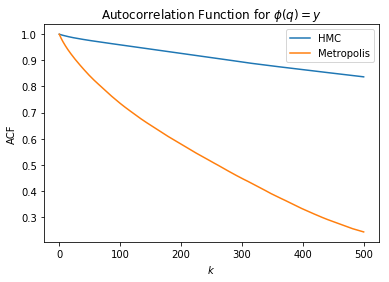

In [172]:
kmax = 500
ac_HMC = acf(q_traj_HMC[:,1],kmax)
ac_M = acf(q_traj_M[:,1],kmax)
plt.plot(range(kmax+1),ac_HMC, label = 'HMC')
plt.plot(range(kmax+1),ac_M , label = 'Metropolis')
plt.xlabel('$k$')
plt.ylabel('ACF')
plt.title('Autocorrelation Function for $\phi (q) = y$')
plt.legend()
plt.show()
    

***
**Optional:**
1. Try running the Metropolis and HMC schemes on the Tomatoes example from last week. Does HMC outperform Metropolis?
2. Compare the HMC method to the Langevin schemes coded last week, which is more efficient?
3. Can you relate the $\gamma$ parameter in Langevin dynamics to the integrated autocorrelation time, for a 1D Normal distribution?
4. For a 1D Normal distribution, what is the optimal acceptance ratio for Metropolis and HMC?
5. Implement and test the MALA scheme given in the lecture slides. Does it offer an improvement?
